# Iris classification

This notebook will walk through the process of using the ITEA for classification (``ITEA_classifier``) and interpreting the final expression with the ``itea.inspection`` tools.

In [1]:
import numpy  as np
import pandas as pd

# automatically differentiable implementation of numpy
import jax.numpy as jnp

from sklearn import datasets

from sklearn.model_selection import train_test_split
from IPython.display         import display, Math, Latex

import matplotlib.pyplot as plt

from itea.classification import ITEA_classifier
from itea.inspection     import *

import warnings
warnings.filterwarnings('ignore')

We will use the Iris data set in this example.

This data set contains 3 different classes of Iris flowers and have 4 features: sepal width, sepal length, petal width and petal length.

One example of each flower is illustred in the figure below.

![](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Machine+Learning+R/iris-machinelearning.png)

In [2]:
iris_data = datasets.load_iris()
X, y      = iris_data['data'], iris_data['target']
labels    = np.array(iris_data['feature_names'])
targets   = iris_data['target_names']

# changing numbers to the class names
y_targets = [targets[yi] for yi in y]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_targets, test_size=0.33, random_state=42)

# Creating transformation functions for ITEA using jax.numpy
# (so we don't need to analytically calculate its derivatives)
tfuncs = {
    'id'       : lambda x: x,
    'sqrt.abs' : lambda x: jnp.sqrt(jnp.abs(x)), 
    'log'      : jnp.log,
    'sin'      : jnp.sin,
    'cos'      : jnp.cos,
    'exp'      : jnp.exp
}

clf = ITEA_classifier(
    gens            = 50,
    popsize         = 50,
    max_terms       = 5,
    expolim         = (-2, -2),
    verbose         = 5,
    tfuncs          = tfuncs,
    labels          = labels,
    simplify_method = 'simplify_by_var',
    random_state    = 42,
).fit(X_train, y_train)



gen 	 min_fitness 	 mean_fitness 	 max_fitness 	 remaining (s)
0 	 0.37 	 0.9059999999999999 	 0.93 	 1min0seg
5 	 0.93 	 0.93 	 0.93 	 0min55seg
10 	 0.93 	 0.93 	 0.93 	 0min48seg
15 	 0.93 	 0.93 	 0.93 	 0min41seg
20 	 0.93 	 0.93 	 0.93 	 0min36seg
25 	 0.93 	 0.93 	 0.93 	 0min30seg
30 	 0.93 	 0.93 	 0.93 	 0min28seg
35 	 0.93 	 0.93 	 0.93 	 0min18seg


Now that we have fitted the ITEA, our ``clf`` contains the ``bestsol_`` attribute, which is an fitted instance of ``ITExpr_classifier`` ready to be used.

In [14]:
final_itexpr = clf.bestsol_

final_itexpr.to_str(term_separator='\n')

'[ 2.043  0.152 -2.195]*log(sepal length (cm)^-2 * sepal width (cm)^-2 * petal length (cm)^-2 * petal width (cm)^-2)\n[ 15.644   3.747 -19.391]'

We can use the ``ITExpr_inspector`` to obtain metrics regarding the IT terms in the expression

In [15]:
display(pd.DataFrame(
    ITExpr_inspector(
        itexpr=final_itexpr, tfuncs=tfuncs
    ).fit(X_train, y_train).terms_analysis()
))

,coef,func,strengths,coef stderr.,mean pairwise disentanglement,mean mutual information,prediction var.
0,[ 2.043 0.152 -2.195],log,"[-2, -2, -2, -2]",[0.467 0.178 0.465],0.0,0.0,[43.57 0.241 50.288]
1,[ 15.644 3.747 -19.391],intercept,---,[3.002 1.69 4.608],0.0,0.0,[0. 0. 0.]


Now let's create an instance of ``ITExpr_explainer``.

We can calculate feature importances with Partial Effects (PE) or approximate the Shapley values using PE.

/mnt/c/Users/Guilherme Aldeia/Documents/github/interaction-transformation-evolutionary-algorithm/itea/inspection/_ITExpr_explainer.py:61: UserWarning: It wasn't specified a dict for tfuncs_dx. They will be automatically generated using Jax. For this, make sure that the tfuncs uses the jax.numpy instead of numpy to create the transformation functions. You can access the automatic derivatives with explainer.tfuncs_dx.
  warnings.warn("It wasn't specified a dict for tfuncs_dx. "


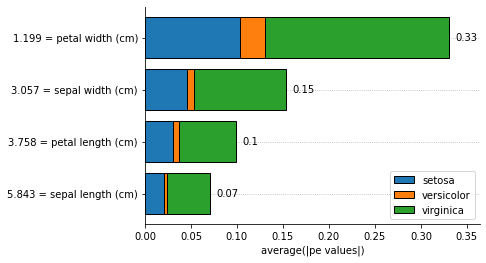

In [11]:
explainer = ITExpr_explainer(
    itexpr=final_itexpr,
    tfuncs=tfuncs
).fit(X_train, y_train)

explainer.plot_feature_importances(
    importance_method='pe', # change to 'shapley'
    grouping_threshold=0.0,
    target=None,
    barh_kw={'edgecolor':'k'},
    show=False
)

Instead of looking into the average Partial Effects, we can plot the Partial Effects for each variable when its co-variables are fixed at the means.

In [1]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

explainer.plot_partial_effects_at_means(
    X          = X_test, # Obtaining explanations for test data 
    ax         = axs,
    features   = final_itexpr.labels,
    target     = None,
    num_points = 100,
    share_y    = False,
    show_err   = False,
    show       = True,
)

plt.tight_layout()

NameError: name 'plt' is not defined